In [13]:
from sql_functions import get_dataframe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")
RSEED = 10

In [14]:
schema = "bgg_data"
main = "main"
marketplace = "marketplace_listings"
stats = "statistics"

df_main = get_dataframe(f"SELECT * FROM {schema}.{main}")
df_marketplace = get_dataframe(f"SELECT * FROM {schema}.{marketplace}")
df_stats = get_dataframe(f"SELECT * FROM {schema}.{stats}")


In [15]:
df_stats.describe()

,id,average,user_rated,num_owned,trading,wanting,wishing,numcomments,numweights,averageweight
count,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000,333291.000000
mean,183916.420017,3.161881,71.939248,155.410941,3.958355,4.233349,20.780045,18.239217,3.909737,0.456766
std,105796.233019,3.441298,1031.186407,1586.239315,29.820136,33.389891,224.978813,188.878053,55.968413,0.976645
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92592.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,185086.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,275956.500000,6.625000,4.000000,19.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
max,365842.000000,10.000000,112718.000000,175618.000000,2655.000000,2008.000000,20091.000000,19916.000000,7809.000000,5.000000


In [16]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137153 entries, 0 to 137152
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   id             137153 non-null  int64
 1   yearpublished  137153 non-null  int64
 2   min_players    137153 non-null  int64
 3   max_players    137153 non-null  int64
 4   playtime       137153 non-null  int64
 5   min_playtime   137153 non-null  int64
 6   max_playtime   137153 non-null  int64
 7   min_age        137153 non-null  int64
dtypes: int64(8)
memory usage: 8.4 MB


In [17]:
df_log_reg = pd.merge(df_main, df_stats, how="inner", on="id")
df_log_reg = pd.merge(df_log_reg, df_marketplace, how="inner", on="id")


In [18]:
df_log_reg

,id,yearpublished,min_players,max_players,playtime,min_playtime,max_playtime,min_age,average,user_rated,...,wishing,numcomments,numweights,averageweight,listdate,price,currency,condition,conv_currency,price_in_dollars
0,98443,2012,1,4,90,90,90,10,6.72745,286,...,177,137,21,2.6667,2018-08-27,50.00,GBP,verygood,1.21,60.5000
1,98443,2012,1,4,90,90,90,10,6.72745,286,...,177,137,21,2.6667,2019-03-25,115.00,EUR,likenew,1.03,118.4500
2,98443,2012,1,4,90,90,90,10,6.72745,286,...,177,137,21,2.6667,2019-08-25,110.00,EUR,likenew,1.03,113.3000
3,98443,2012,1,4,90,90,90,10,6.72745,286,...,177,137,21,2.6667,2020-03-06,150.00,USD,verygood,1.00,150.0000
4,98443,2012,1,4,90,90,90,10,6.72745,286,...,177,137,21,2.6667,2020-12-24,60.00,EUR,verygood,1.03,61.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234351,298166,2020,2,6,5,5,5,8,6.57194,134,...,23,29,8,1.1250,2021-08-07,10.00,USD,new,1.00,10.0000
234352,298173,2020,2,6,5,5,5,8,6.55657,99,...,24,22,4,1.0000,2022-01-30,5.00,EUR,verygood,1.03,5.1500
234353,298175,2020,2,6,180,60,180,13,7.37500,8,...,28,2,0,0.0000,2020-08-08,34.00,EUR,new,1.03,35.0200
234354,298175,2020,2,6,180,60,180,13,7.37500,8,...,28,2,0,0.0000,2020-11-03,33.99,EUR,new,1.03,35.0097


In [19]:
df_log_reg["sales"] = df_log_reg["price"] * df_log_reg["num_owned"]

In [20]:
sales_target = 5_000

In [21]:
df_log_reg["target_reached"] = pd.cut(df_log_reg["sales"], bins= [0, sales_target, float('Inf')], labels= [0, 1])

In [22]:
df_log_reg["target_reached"] = df_log_reg["target_reached"].fillna(0)

In [23]:
df_log_reg

,id,yearpublished,min_players,max_players,playtime,min_playtime,max_playtime,min_age,average,user_rated,...,numweights,averageweight,listdate,price,currency,condition,conv_currency,price_in_dollars,sales,target_reached
0,98443,2012,1,4,90,90,90,10,6.72745,286,...,21,2.6667,2018-08-27,50.00,GBP,verygood,1.21,60.5000,26400.00,1
1,98443,2012,1,4,90,90,90,10,6.72745,286,...,21,2.6667,2019-03-25,115.00,EUR,likenew,1.03,118.4500,60720.00,1
2,98443,2012,1,4,90,90,90,10,6.72745,286,...,21,2.6667,2019-08-25,110.00,EUR,likenew,1.03,113.3000,58080.00,1
3,98443,2012,1,4,90,90,90,10,6.72745,286,...,21,2.6667,2020-03-06,150.00,USD,verygood,1.00,150.0000,79200.00,1
4,98443,2012,1,4,90,90,90,10,6.72745,286,...,21,2.6667,2020-12-24,60.00,EUR,verygood,1.03,61.8000,31680.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234351,298166,2020,2,6,5,5,5,8,6.57194,134,...,8,1.1250,2021-08-07,10.00,USD,new,1.00,10.0000,3790.00,0
234352,298173,2020,2,6,5,5,5,8,6.55657,99,...,4,1.0000,2022-01-30,5.00,EUR,verygood,1.03,5.1500,1355.00,0
234353,298175,2020,2,6,180,60,180,13,7.37500,8,...,0,0.0000,2020-08-08,34.00,EUR,new,1.03,35.0200,2720.00,0
234354,298175,2020,2,6,180,60,180,13,7.37500,8,...,0,0.0000,2020-11-03,33.99,EUR,new,1.03,35.0097,2719.20,0


In [24]:
df_log_reg = df_log_reg.drop(["id", "yearpublished", "listdate", "user_rated", "num_owned", "trading", "wanting", "wishing", "numcomments", "numweights"], axis=1)

In [25]:
df_log_reg = df_log_reg.drop(["condition", "average", "sales", "averageweight", "currency", "price", "conv_currency"], axis=1)

In [26]:
df_log_reg

,min_players,max_players,playtime,min_playtime,max_playtime,min_age,price_in_dollars,target_reached
0,1,4,90,90,90,10,60.5000,1
1,1,4,90,90,90,10,118.4500,1
2,1,4,90,90,90,10,113.3000,1
3,1,4,90,90,90,10,150.0000,1
4,1,4,90,90,90,10,61.8000,1
...,...,...,...,...,...,...,...,...
234351,2,6,5,5,5,8,10.0000,0
234352,2,6,5,5,5,8,5.1500,0
234353,2,6,180,60,180,13,35.0200,0
234354,2,6,180,60,180,13,35.0097,0


In [27]:
# Define predictors and target
y = df_log_reg.target_reached
X = df_log_reg.drop('target_reached', axis=1)

In [28]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 234356 entries, 0 to 234355
Series name: target_reached
Non-Null Count   Dtype   
--------------   -----   
234356 non-null  category
dtypes: category(1)
memory usage: 2.0 MB


In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234356 entries, 0 to 234355
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   min_players       234356 non-null  int64  
 1   max_players       234356 non-null  int64  
 2   playtime          234356 non-null  int64  
 3   min_playtime      234356 non-null  int64  
 4   max_playtime      234356 non-null  int64  
 5   min_age           234356 non-null  int64  
 6   price_in_dollars  234356 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 14.3 MB


In [30]:
# Check for missing data
df_log_reg.isnull().sum()

min_players         0
max_players         0
playtime            0
min_playtime        0
max_playtime        0
min_age             0
price_in_dollars    0
target_reached      0
dtype: int64

In [31]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
classifier = LogisticRegression() # instantiate a sklearn logistic regression class
classifier.fit(X_train, y_train) # fit the classifier/model on our train data 
y_prediction = classifier.predict(X_test) # use the fit model to predict on our test data 

#have a look at the predicitons
y_prediction[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.69      0.37      0.48     12298
           1       0.81      0.94      0.87     34574

    accuracy                           0.79     46872
   macro avg       0.75      0.65      0.67     46872
weighted avg       0.78      0.79      0.77     46872



In [44]:
#import all the classifiers you want to evaluate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [45]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(random_state=RSEED)))

In [46]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.786120 (0.003496)
LDA: 0.744149 (0.001093)
KNN: 0.836034 (0.001413)
NB: 0.330034 (0.037264)
SGD: 0.746229 (0.013774)


In [49]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
display(df_log_reg.describe().round(2))
col_scale = ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'min_age', 'price_in_dollars']

,min_players,max_players,playtime,min_playtime,max_playtime,min_age,price_in_dollars
count,234356.00,234356.00,234356.00,234356.00,234356.00,234356.00,2.343560e+05
mean,1.91,5.14,107.17,67.50,106.63,10.39,9.769300e+02
std,0.71,8.96,3275.94,244.93,3275.95,3.65,2.977323e+05
min,0.00,0.00,0.00,0.00,0.00,0.00,6.800000e-01
25%,2.00,4.00,30.00,30.00,30.00,8.00,1.210000e+01
50%,2.00,4.00,60.00,45.00,60.00,12.00,2.400000e+01
75%,2.00,6.00,120.00,75.00,120.00,13.00,4.235000e+01
max,10.00,999.00,1576800.00,60000.00,1576800.00,112.00,1.030000e+08


In [50]:
# Scaling with standard scaler
# the fit part method is calculating the mean and the variance of the data
# fit_transform applies this to transform all the features in respect to that values
# transform applies this to new data in respect to that already learned values, not the new data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [51]:
# Scaling with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [52]:
# Define predictors and target
y2 = df_log_reg.target_reached
X2 = df_log_reg.drop('target_reached', axis=1)

In [53]:
# Train-test-split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [54]:
# Scaling with minmax scaler
mmscaler = MinMaxScaler()
X2_train_scaled = mmscaler.fit_transform(X2_train[col_scale])
X2_test_scaled = mmscaler.transform(X2_test[col_scale])

In [55]:
# Concatenating scaled and dummy columns
X2_train_preprocessed = np.concatenate([X2_train_scaled, X2_train.drop(col_scale, axis=1)], axis=1)
X2_test_preprocessed = np.concatenate([X2_test_scaled, X2_test.drop(col_scale, axis=1)], axis=1)

In [56]:
print("test", pd.DataFrame(X2_train_preprocessed).describe())
print("---")
print("train", pd.DataFrame(X2_test_preprocessed).describe())

test                    0              1              2              3  \
count  187484.000000  187484.000000  187484.000000  187484.000000   
mean        0.190877       0.005135       0.001124       0.000069   
std         0.071388       0.008719       0.004247       0.002321   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.200000       0.004004       0.000500       0.000019   
50%         0.200000       0.004004       0.000750       0.000038   
75%         0.200000       0.006006       0.001250       0.000076   
max         1.000000       1.000000       1.000000       1.000000   

                   4             5             6  
count  187484.000000  1.874840e+05  1.874840e+05  
mean        0.092821  6.554407e-06  1.088504e+02  
std         0.032617  2.328417e-03  3.659137e+03  
min         0.000000  0.000000e+00  0.000000e+00  
25%         0.071429  1.142000e-07  3.000000e+01  
50%         0.107143  2.332000e-07  6.000000e+01  
75%         0.11

In [76]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
knn_classifier = KNeighborsClassifier()
scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

Score (unscaled): 0.8346


In [107]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
lr_classifier = LogisticRegression()
lr_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(lr_scores.mean(), 4))

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Score (unscaled): 0.7859


/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

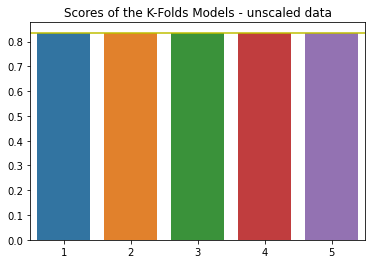

In [77]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4,5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

In [78]:
# Fit and evaluate model using cross validation and scaled data 
knn_scaled = KNeighborsClassifier()
scores_scaled_std = cross_val_score(knn_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled_std.mean(), 4))

Score (scaled): 0.8439


In [108]:
# Fit and evaluate model using cross validation and scaled data 
lr_scaled = LogisticRegression()
lr_scores_scaled_std = cross_val_score(lr_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(lr_scores_scaled_std.mean(), 4))

Score (scaled): 0.7484


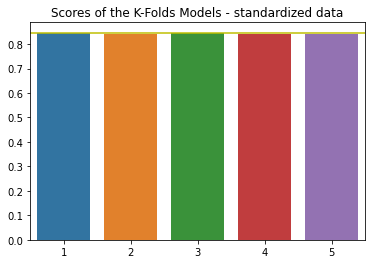

In [79]:
plt.axhline(y=scores_scaled_std.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4,5],y=scores_scaled_std).set_title('Scores of the K-Folds Models - standardized data');

Score (scaled): 0.8443


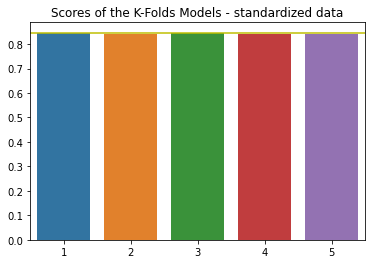

In [80]:
# Fit and evaluate model using cross validation and scaled data 
knn_scaled = KNeighborsClassifier()
scores_scaled_norm = cross_val_score(knn_scaled, X2_train_preprocessed, y_train, cv=5, n_jobs=-1, scoring='accuracy')
# If "scoring"=None, the estimator’s default scorer (if available) is used.

# Evaluation
print('Score (scaled):', round(scores_scaled_norm.mean(), 4))

plt.axhline(y=scores_scaled_norm.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled_norm).set_title('Scores of the K-Folds Models - standardized data');

Score (scaled): 0.7413


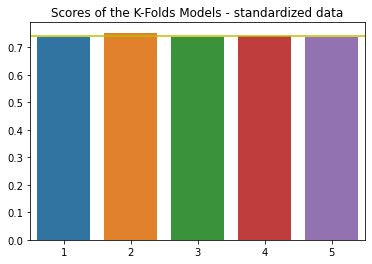

In [109]:
# Fit and evaluate model using cross validation and scaled data 
lr_scaled = LogisticRegression()
lr_scores_scaled_norm = cross_val_score(lr_scaled, X2_train_preprocessed, y_train, cv=5, n_jobs=-1, scoring='accuracy')
# If "scoring"=None, the estimator’s default scorer (if available) is used.

# Evaluation
print('Score (scaled):', round(lr_scores_scaled_norm.mean(), 4))

plt.axhline(y=lr_scores_scaled_norm.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=lr_scores_scaled_norm).set_title('Scores of the K-Folds Models - standardized data');

In [81]:
print('Score (unscaled):', round(scores.mean(), 4))
print('Score (scaled, standardized):', round(scores_scaled_std.mean(), 4))
print('Score (scaled, normalized):', round(scores_scaled_norm.mean(), 4))

Score (unscaled): 0.8346
Score (scaled, standardized): 0.8439
Score (scaled, normalized): 0.8443


In [110]:
print('Score (unscaled):', round(lr_scores.mean(), 4))
print('Score (scaled, standardized):', round(lr_scores_scaled_std.mean(), 4))
print('Score (scaled, normalized):', round(lr_scores_scaled_norm.mean(), 4))

Score (unscaled): 0.7859
Score (scaled, standardized): 0.7484
Score (scaled, normalized): 0.7413


In [84]:
knn_classifier.get_params()#.keys()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [112]:
lr_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [86]:
from timeit import default_timer as timer
# Defining parameter grid (as dictionary)
param_grid = {"algorithm" : ["auto", "ball_tree", "kd_tree"],
              "weights" : ["uniform", "distance"],
              "p" : [1, 2]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(knn_classifier, param_grid, scoring='accuracy',
                  cv=5, verbose=1)

# Fit gridsearch object to data. Also lets see how long it takes.
start = timer()
gs.fit(X_train, y_train)
end = timer()
gs_time = end-start

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [113]:
param_grid = {"solver" : ["lbfgs", "liblinear", "newton-cg’", "sag", "saga"],
              "penalty" : ["l2", "l1", "elasticnet"],
              "fit_intercept" : [True, False]
             }

# Instantiate gridsearch and define the metric to optimize 
lr_gs = GridSearchCV(lr_classifier, param_grid, scoring='accuracy',
                  cv=5, verbose=1)

# Fit gridsearch object to data. Also lets see how long it takes.
start = timer()
lr_gs.fit(X2_train_preprocessed, y_train)
end = timer()
gs_time = end-start

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [87]:
# Best score
print('Best score:', round(gs.best_score_, 3))
print('Score (unscaled):', round(scores.mean(), 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.837
Score (unscaled): 0.835
Best parameters: {'algorithm': 'auto', 'p': 1, 'weights': 'uniform'}


In [114]:
# Best score
print('Best score:', round(lr_gs.best_score_, 3))
print('Score (unscaled):', round(lr_scores.mean(), 3))

# Best parameters
print('Best parameters:', lr_gs.best_params_)

Best score: 0.751
Score (unscaled): 0.786
Best parameters: {'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}


In [89]:
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('solver: {}'.format(model.solver))
    print('fit_intercept: {}'.format(model.fit_intercept))
    print('penalty: {}'.format(model.penalty))
    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

def print_pretty_summary_knn(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('algorithm: {}'.format(model.algorithm))
    print('weights: {}'.format(model.weights))
    print('p: {}'.format(model.p))
    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [117]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gs.best_estimator_

lr_best = lr_gs.best_estimator_

# Making predictions on the test set
y_pred_test_gs_kn = knn_best.predict(X_test)
y_pred_test_gs_lr = lr_best.predict(X_test)
# Let us print out the performance of our model on the test set.
lr_gs_accuracy = print_pretty_summary('LR Classifier model', lr_best, y_test, y_pred_test_gs_lr)

LR Classifier model
solver: liblinear
fit_intercept: False
penalty: l1
Test accuracy: 0.747653


In [120]:
y_pred_test_gs_lr

array([1, 0, 1, ..., 1, 1, 1])

In [122]:
y_test

64530     0
217257    1
74090     1
111755    1
56266     0
         ..
89751     0
196971    1
140594    1
233476    0
213639    1
Name: target_reached, Length: 46872, dtype: category
Categories (2, int64): [0 < 1]

In [121]:
#Have a look at the confusion matrix below
confusion_matrix(y_test, y_pred_test_gs_kn)

TypeError: 'DataFrame' object is not callable

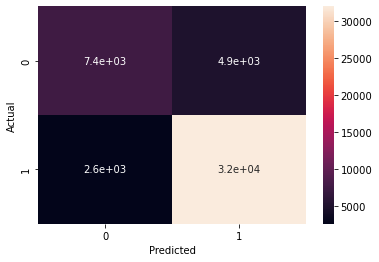

In [123]:
confusion_matrix = pd.crosstab(y_test, y_pred_test_gs_kn, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

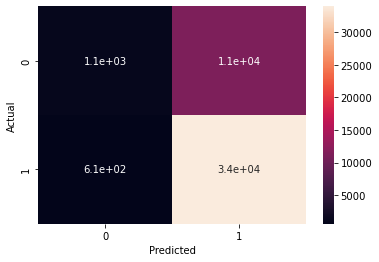

In [124]:
confusion_matrix = pd.crosstab(y_test, y_pred_test_gs_lr, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);